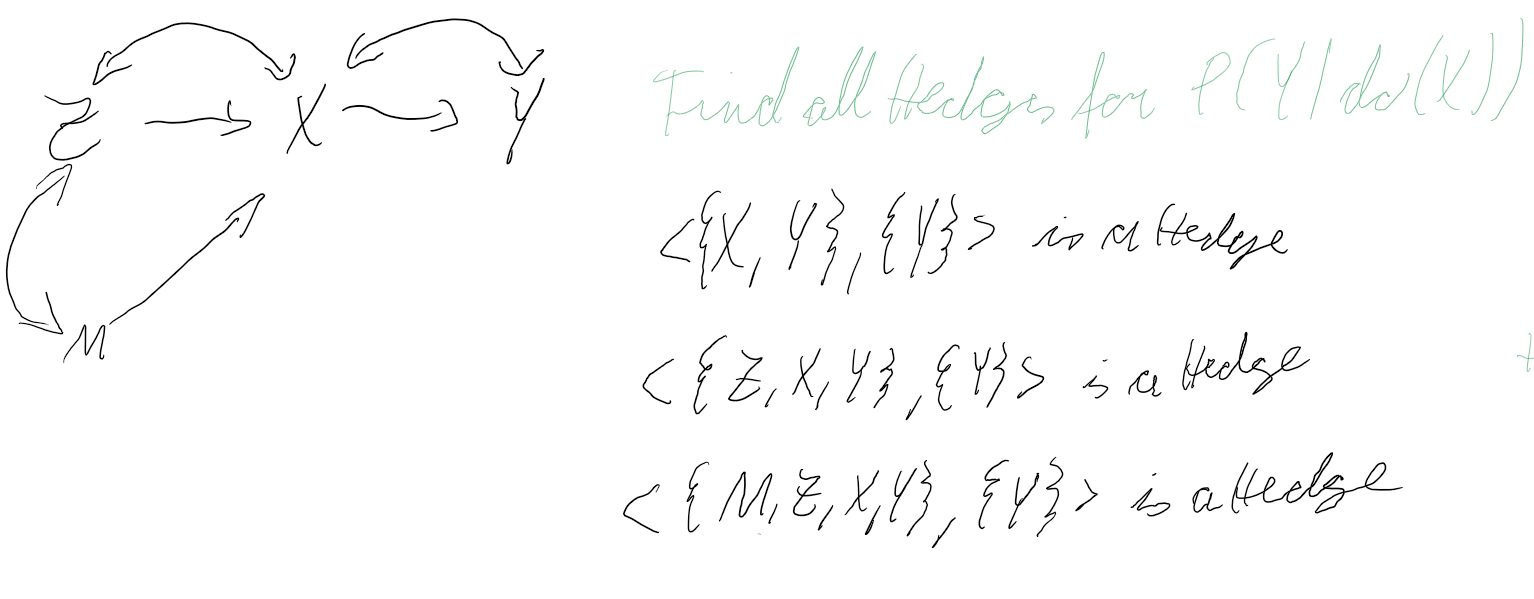

Hypothesis: $W_Z < W_M$, because $do(Z)$ destroys more Hedges than $do(M)$

In [24]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
from autobound.Query import Query
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [18]:
# --- DAG: Z->X, M->X, X->Y; and Z<->M, Z<->X, X<->Y
dag = DAG()
dag.from_structure(
    "Z -> X, M -> X, X -> Y, "
    "U_ZM -> Z, U_ZM -> M, "   # Z <-> M
    "U_ZX -> Z, U_ZX -> X, "   # Z <-> X
    "U_XY -> X, U_XY -> Y",    # X <-> Y
    unob="U_ZM,U_ZX,U_XY"
)

# Binary by default; can pass explicit domain sizes if you ever need non-binary
obs = causalProblem(dag, number_values={'Z':2,'M':2,'X':2,'Y':2})

In [19]:
obs.load_data('obs.csv')      # adds equalities P(z,m,x,y) = prob
obs.add_prob_constraints()    # ensures each response-function block sums to 1

c:\ProgramData\miniconda3\Lib\site-packages\autobound\causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
c:\ProgramData\miniconda3\Lib\site-packages\autobound\causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = [ f'{row_data.index[j]}={int(row_data[j])}'
c:\ProgramData\miniconda3\Lib\site-packages\autobound\causalProblem.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

In [20]:
obs.set_estimand(obs.query('Y(X=1)=1'))   # encodes: P(Y(1)=1) - objvar = 0

prog = obs.write_program()
lower, upper = prog.run_pyomo('glpk', verbose=False)   # pyomo solvers: glpk, ipopt..
print(f"P(Y=1 | do(X=1)) ∈ [{lower:.4f}, {upper:.4f}]")


P(Y=1 | do(X=1)) ∈ [0.2500, 0.7500]


In [31]:
#Simulate intervention on M
doM = causalProblem(dag, number_values={'Z':2,'M':2,'X':2,'Y':2})
doM.load_data('obs.csv')      
doM.add_prob_constraints() 

# Add uniform experimental distribution P(Z,X,Y | do(M))
# Each m in {0,1}, each z,x,y in {0,1}, probability 1/8 (since 8 combos per m)
p = 1/8  # 8 cells per m

for m in [0, 1]:
    for z in [0, 1]:
        for x in [0, 1]:
            for y in [0, 1]:
                # Two equivalent ways to write the left-hand side:

                # A) Literal potential outcomes on all three:
                lhs = doM.query(f'Z(M={m})={z}&X(M={m})={x}&Y(M={m})={y}')

                # B) Since M -> X and X -> Y but M !-> Z in your DAG,
                #    Z is unaffected by do(M). This is a bit simpler:
                # lhs = doM.query(f'Z={z}&X(M={m})={x}&Y(M={m})={y}')

                # Add equality: P(...) = p
                doM.add_constraint(lhs - Query(p))

doM.set_estimand(doM.query('Y(X=1)=1'))
prog_doM = doM.write_program()
lb, ub = prog_doM.run_pyomo('glpk', verbose=False)   # or 'ipopt' if you prefer
print(f"P(Y=1 | do(X=1)) ∈ [{lb:.4f}, {ub:.4f}]")

P(Y=1 | do(X=1)) ∈ [0.2500, 0.7500]


In [33]:
#Simulate intervention on Z
doZ = causalProblem(dag, number_values={'Z':2,'M':2,'X':2,'Y':2})
doZ.load_data('obs.csv')      
doZ.add_prob_constraints() 

# Add uniform experimental distribution P(M,X,Y | do(Z))
# For each z in {0,1}, there are 2*2*2 = 8 cells over (M,X,Y) → each is 1/8.
p = 1/8

for z in [0, 1]:
    for m in [0, 1]:
        for x in [0, 1]:
            for y in [0, 1]:
                # Two equivalent encodings of the LHS:

                # A) Literal PO on all three:
                lhs = doZ.query(f'M(Z={z})={m}&X(Z={z})={x}&Y(Z={z})={y}')

                # B) Since Z has no directed edge to M (M is not a descendant of Z),
                #    you can leave M as-is and only potentialize descendants:
                # lhs = doZ.query(f'M={m}&X(Z={z})={x}&Y(Z={z})={y}')

                doZ.add_constraint(lhs - Query(p))

doZ.set_estimand(doZ.query('Y(X=1)=1'))
prog_doZ = doZ.write_program()
lb, ub = prog_doZ.run_pyomo('glpk', verbose=False)   
print(f"P(Y=1 | do(X=1)) ∈ [{lb:.4f}, {ub:.4f}]")

P(Y=1 | do(X=1)) ∈ [0.2500, 0.7500]


I assume all W are the same because I chose every distriution perfectly semetric/uniform. I will need to create some synthetic SCM data